# Library

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from wordcloud import WordCloud
import networkx as nx
from typing import Union
from bertopic import BERTopic

# 1 Baseline Summary

## Clustering Approach

- **Parameter Setting**: A high parameter was set for HDBSCAN to ensure well-defined clusters that occupy a significant percentage of the total dataset. This baseline is intended to feed machine learning algorithms for prediction purposes.
  
## Initial Clustering Results

- **Clusters Retrieved**: 7 representative clusters were identified:
  1. **Drug sales**
  2. **Bitcoin**
  3. **Scammers and seller reviews**
  4. **Marketplace advertising**
  5. **Purchase reviews**
  6. **Drug purchases**
  7. **Orders**

- **Outliers**: Initially, 34k outliers were found out of a total of 66k records.

- **Performance Metrics**:
  - **Silhouette Score**: 0.64
  - **Davies-Bouldin Score**: 0.6
  - **Coherence-Score**: 0.40

## Outlier Reduction

- **Cosine Measure on Embeddings**: By applying a cosine similarity measure with a 0.53 threshold, the number of outliers was reduced from 34k to 27k, reintroducing about 7k records.

- **Updated Performance Metrics**:
  - **Silhouette Score**: 0.51
  - **Davies-Bouldin Score**: 0.8
  - **Coherence-Score**: 0.40
  
## Trade-off Analysis

- **Outlier Reintroduction**: Reintroducing the outliers found a balance that prevented significant cluster degradation while keeping clusters well separated and defined, as evidenced by the graphs.

- **Cluster Distribution**: The updated clusters are well-distributed:
  - **Maximum cluster size**: 23% of the total dataset
  - **Minimum cluster size**: 7% of the total dataset
  - This distribution avoids large excursions.

## Data Loss and Potential Adjustments

- **Data Loss**: Approximately 40% of the initial dataset was lost. 

- **Potential Correction**: This data loss can potentially be mitigated by lowering the cosine similarity threshold between embeddings.

# Function

In [94]:
def create_wordclouds(data: Union[BERTopic, pd.DataFrame], num_topics: int, cols: int = 3, is_model: bool = True) -> None:
    """
    Create word clouds for each topic based on either a BERTopic model or a DataFrame.
    :param data: BERTopic model or DataFrame containing 'Topic' and 'Document' columns.
    :param num_topics: Number of topics to create word clouds.
    :param cols: Number of columns in the plot.
    :param is_model: Boolean flag indicating if the data is a BERTopic model (True) or a DataFrame (False).
    """
    rows = math.ceil(num_topics / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), sharex=True, sharey=True)
    axes = axes.flatten()
    
    if is_model:
        # Using BERTopic model
        for i in range(num_topics):
            ax = axes[i]
            text = {word: value for word, value in data.get_topic(i)}
            wc = WordCloud(background_color="black", max_words=1000, width=1200, height=500)
            wc.generate_from_frequencies(text)
            
            ax.imshow(wc, interpolation="bilinear")
            ax.axis("off")
            ax.set_title(f'Topic {i}', fontsize=16)
    else:
        # Using DataFrame
        text_by_topic = data.groupby('Topic')['Document'].apply(lambda x: ' '.join(x)).reset_index()
        
        for i in range(num_topics):
            if i < len(text_by_topic):
                ax = axes[i]
                document_text = text_by_topic.loc[text_by_topic['Topic'] == i, 'Document'].values[0]
                wc = WordCloud(background_color="black", max_words=1000, width=1200, height=500)
                wc.generate(document_text)
                
                ax.imshow(wc, interpolation="bilinear")
                ax.axis("off")
                ax.set_title(f'Topic {i}', fontsize=16)
            else:
                axes[i].axis('off')
    
    # Hide any empty subplots
    for j in range(num_topics, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


def create_network_graphs(df: pd.DataFrame) -> None:
    """
    Create network graphs visualizing relationships between topics and documents for each topic.
    :param df: DataFrame containing 'Topic' and 'Document' columns.
    """
    topics = df['Topic'].unique()
    num_topics = len(topics)
    cols = 2
    rows = math.ceil(num_topics / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for idx, topic in enumerate(topics):
        ax = axes[idx]
        
        # Create a subnetwork for the current topic
        G = nx.DiGraph()
        
        # Add the topic node
        G.add_node(topic, type='topic')
        
        # Add nodes for documents related to the current topic and connect them to the topic node
        topic_docs = df[df['Topic'] == topic]
        for _, row in topic_docs.iterrows():
            document = row['Document']
            G.add_node(document, type='document')
            G.add_edge(document, topic)
        
        # Define node colors and sizes
        node_colors = ['lightblue' if G.nodes[node]['type'] == 'topic' else 'lightgreen' for node in G.nodes]
        node_sizes = [3000 if G.nodes[node]['type'] == 'topic' else 500 for node in G.nodes]
        
        # Draw the network
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, font_size=10, font_weight='bold', arrows=True, ax=ax)
        ax.set_title(f'Topic {topic}', fontsize=16)
    
    # Hide any empty subplots
    for j in range(num_topics, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize Graphs CSV Files

In [ ]:
topic_model = BERTopic.load("../../../Analyze_files/CombiningAnalysisCompleteDataset/ThreadAnalysis/Models/topic_model_0.64SilNew", embedding_model='distiluse-base-multilingual-cased-v1')

In [2]:
descr_topic = pd.read_csv('CSV7Topic/description_topic.csv')
document_topic = pd.read_csv('CSV7Topic/document_topic_proba.csv')
topics_over_time = pd.read_csv('CSV7Topic/topic_over_time_3.csv')

## Topic Description

In [38]:
descr_topic

Topic  Count                                BERTopic_Name  \
0      4   6299                       4_mdma_lsd_get_looking   
1      2   6907                2_vendor_scammer_scam_looking   
2      1   6236              1_market_empire_dream_nightmare   
3      5   2776            5_order_package_shipping_delivery   
4      6   2823                    6_bitcoin_card_wallet_btc   
5      0   8645                  0_weed_xanax_vendor_cocaine   
6      3   4230  3_review_vendor review_vendor_review vendor   

                                      Representation  \
0  ['mdma' 'lsd' 'get' 'looking' 'wsm' 'good' 'bt...   
1  ['vendor' 'scammer' 'scam' 'looking' 'scamming...   
2  ['market' 'empire' 'dream' 'nightmare' 'vendor...   
3  ['order' 'package' 'shipping' 'delivery' 'pack...   
4  ['bitcoin' 'card' 'wallet' 'btc' 'bank' 'credi...   
5  ['weed' 'xanax' 'vendor' 'cocaine' 'mg' 'uk' '...   
6  ['review' 'vendor review' 'vendor' 'review ven...   

                                 Representative_Docs  \
0  ['hey ro im gon na pull pk'\n 'life wonderful ...   
1  ['looking good reliable vendor sell ounce' 've...   
2  ['next market' 'dream market vendor rstclass n...   
3  ['order accepted day still hasnt marked shippe...   
4  ['credit cards paypal prepaid card find'\n 'go...   
5  ['high quality weed thc product europe'\n 'new...   
6  ['empire vendor cocaine review' 'first ever re...   

                 Custom_Name_GenAI           Custom_Name_Zero_Shot  
0                  Drug Discussion                       buy drugs  
1             Trusted Vendor Scams        scammer - vendor scammer  
2           Dream Vendor Nightmare     market drug - empire market  
3        Order Shipping & Tracking                          orders  
4  Financial Services and Products                  bitcoin wallet  
5               Drug Vendor Europe                      sell drugs  
6               Vendor MDMA Review  review vendor - review product

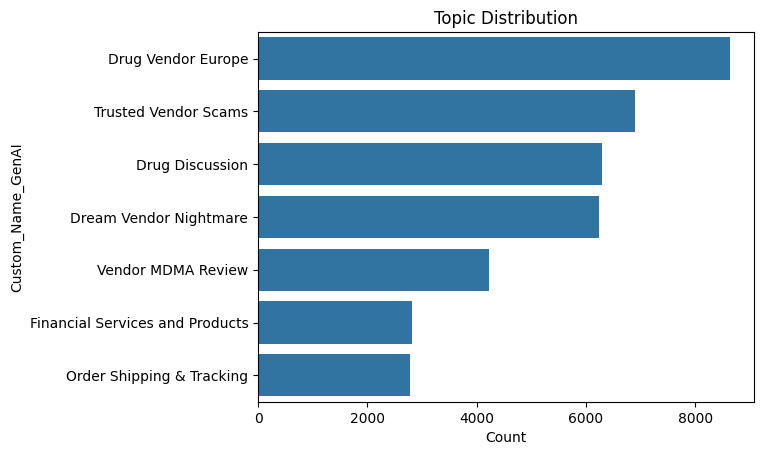

In [53]:
sns.barplot(x='Count', y='Custom_Name_GenAI', data=descr_topic, orient='h', order=descr_topic.sort_values('Count',ascending = False).Custom_Name_GenAI)
plt.title('Topic Distribution');

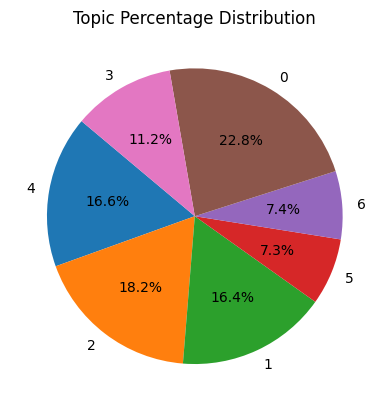

In [56]:
plt.pie(descr_topic['Count'], labels=descr_topic['Topic'], autopct='%1.1f%%', startangle=140)
plt.title('Topic Percentage Distribution');

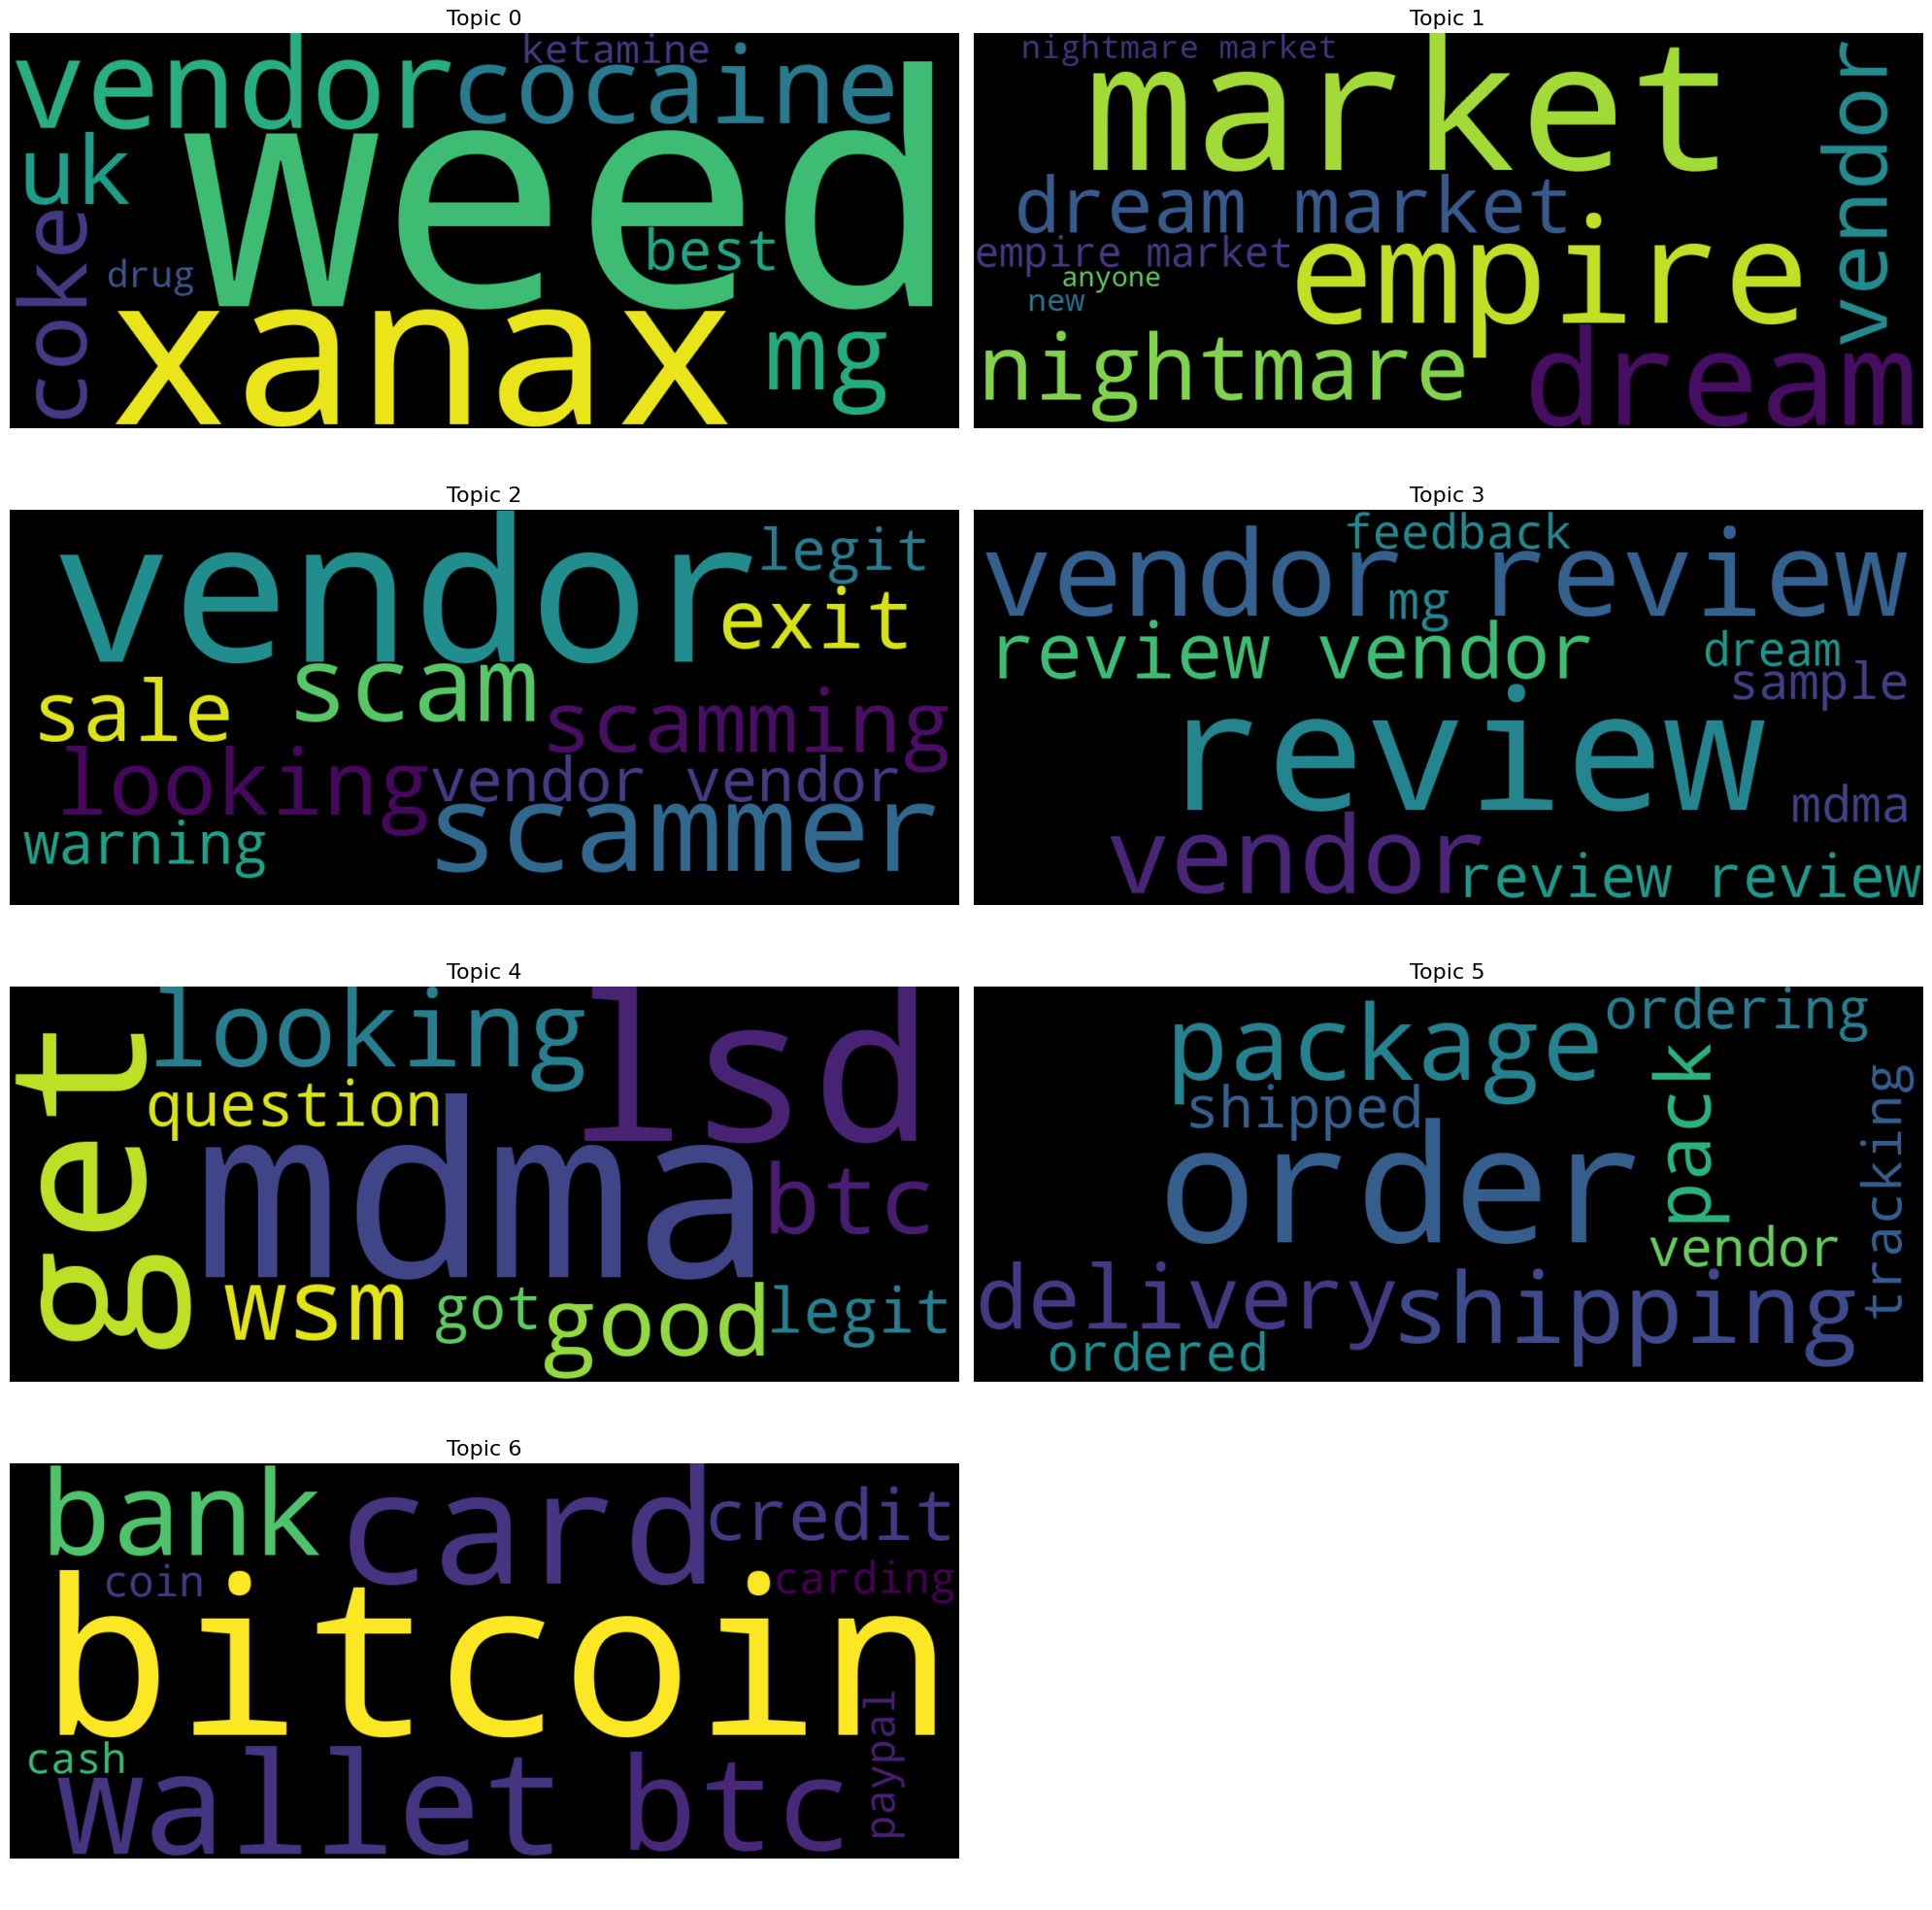

In [91]:
create_wordclouds(topic_model, num_topics=7, cols=2)

## Document Topic Description

In [41]:
print(document_topic.shape[0])
document_topic.head(5)

37916


Document  Topic  Probability  Created_on  \
0                                  checks      4     0.000000  2020-01-09   
1                   trusted vendor status      2     0.944247  2020-01-09   
2  empire exit scam iiflux user incomming      1     1.000000  2019-11-06   
3                    ecstasy vendor packs      5     0.797741  2020-01-09   
4     opening bank account person fake id      6     1.000000  2019-11-06   

                       BERTopic_Name  
0             4_mdma_lsd_get_looking  
1      2_vendor_scammer_scam_looking  
2    1_market_empire_dream_nightmare  
3  5_order_package_shipping_delivery  
4          6_bitcoin_card_wallet_btc

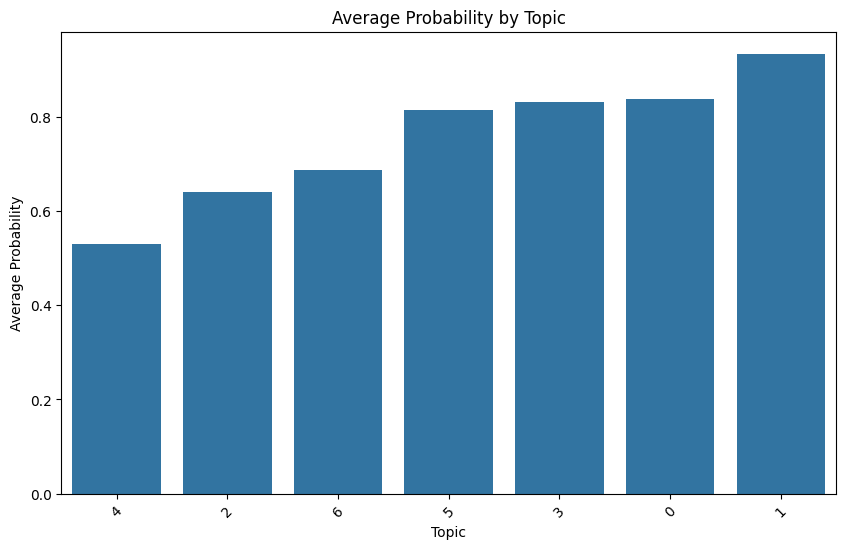

In [62]:
probability_avg = document_topic.groupby('Topic')['Probability'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Topic', y='Probability', data=probability_avg, order=probability_avg.sort_values('Probability').Topic)
plt.title('Average Probability by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Probability')
plt.xticks(rotation=45)
plt.show()

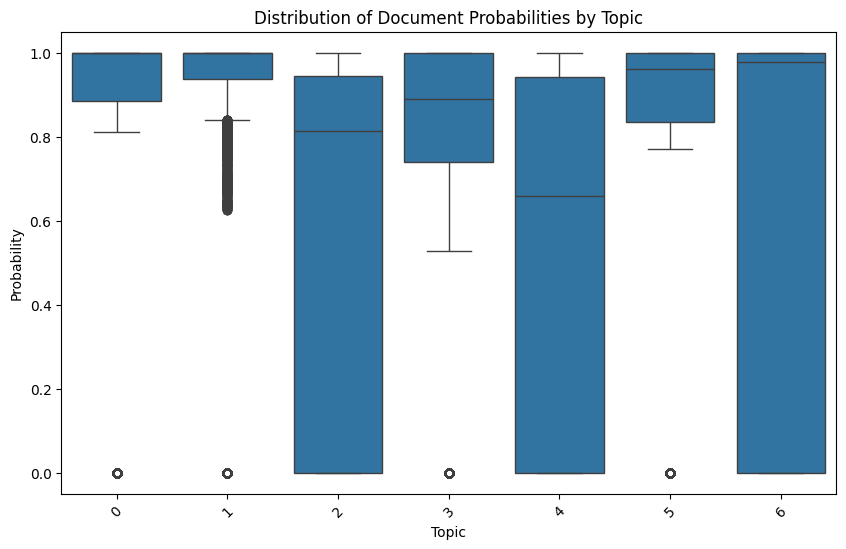

In [66]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Topic', y='Probability', data=document_topic)
plt.title('Distribution of Document Probabilities by Topic')
plt.xlabel('Topic')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()

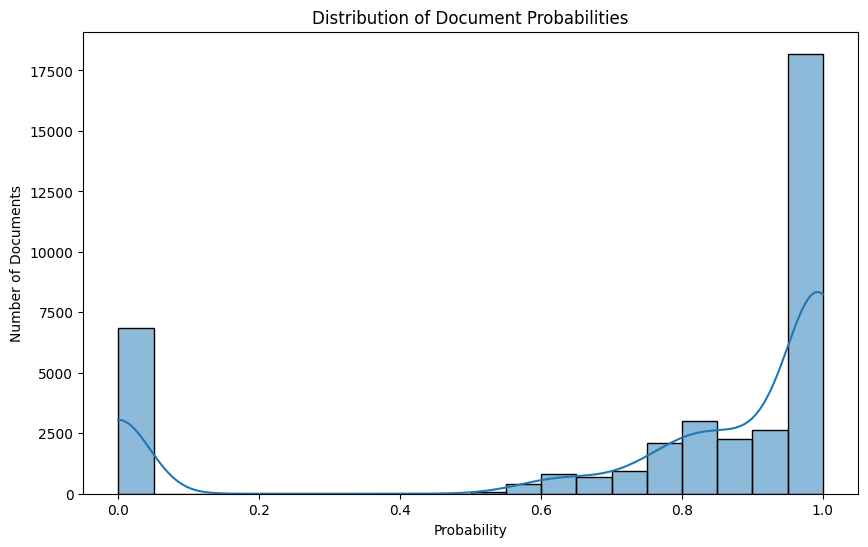

In [69]:
plt.figure(figsize=(10, 6))
sns.histplot(document_topic['Probability'], bins=20, kde=True)
plt.title('Distribution of Document Probabilities')
plt.xlabel('Probability')
plt.ylabel('Number of Documents')
plt.show()

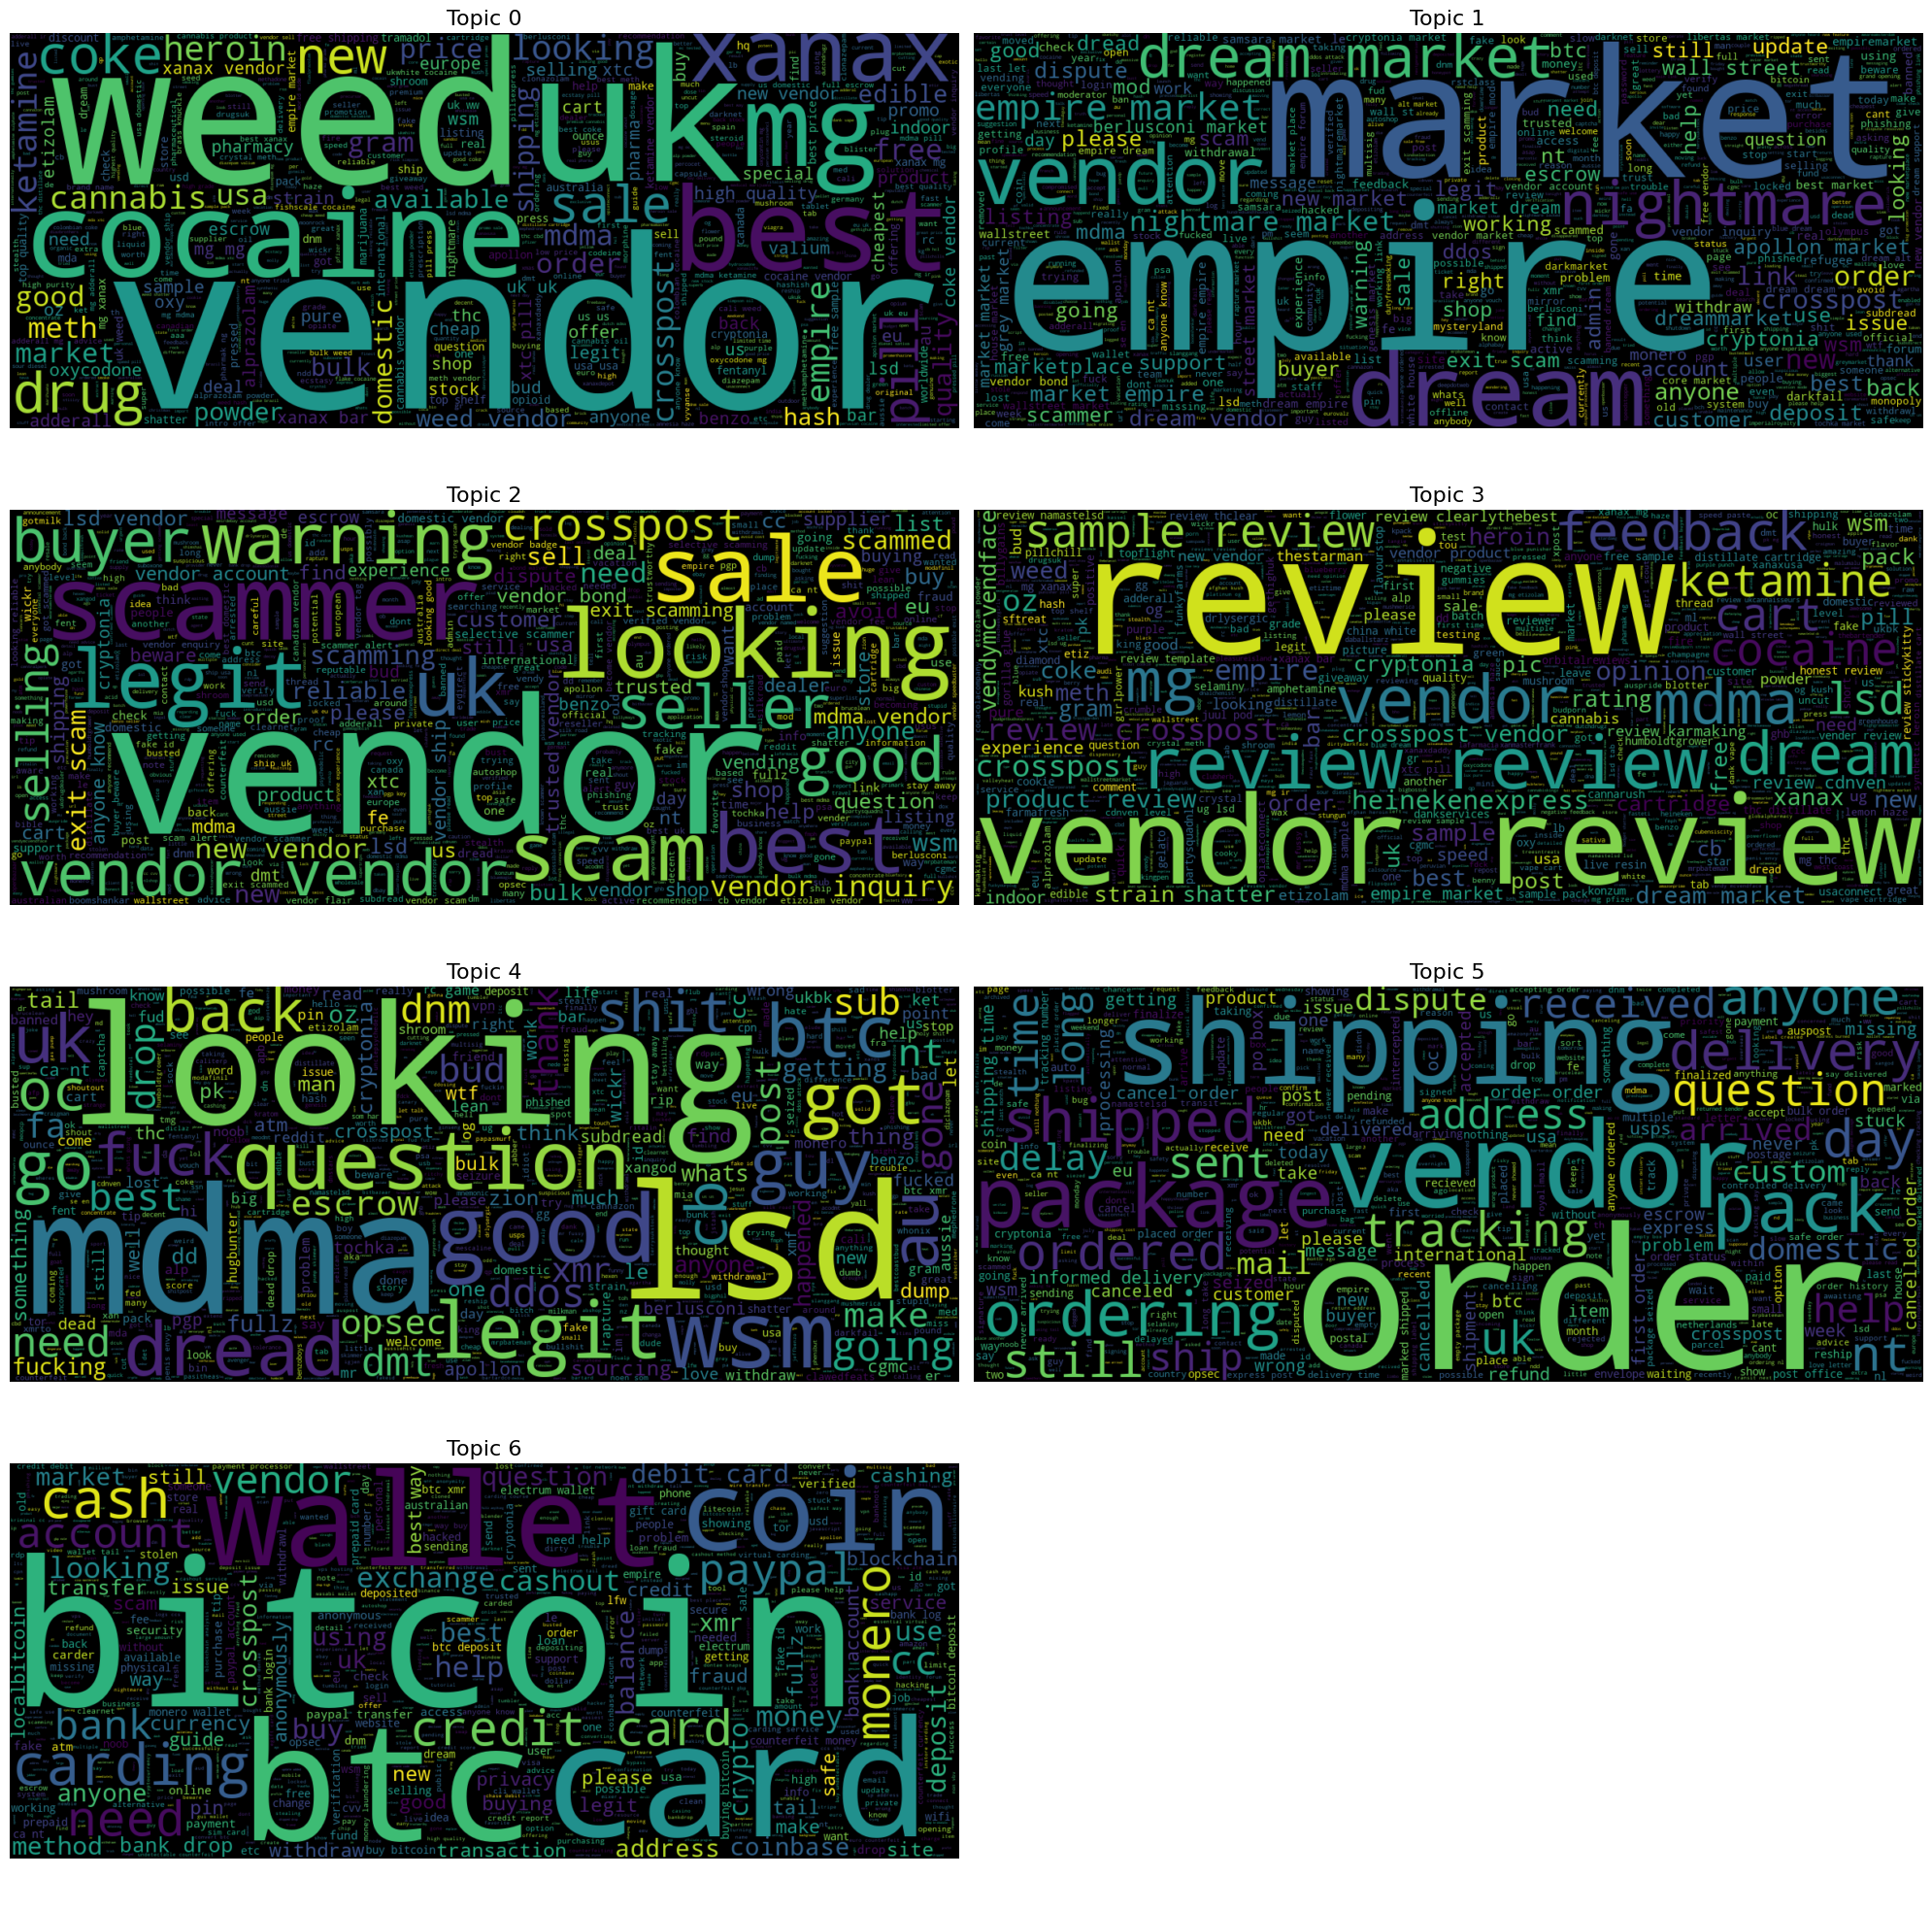

In [90]:
create_wordclouds(document_topic, num_topics=7, cols=2, is_model=False)

In [95]:
create_network_graph(document_topic)

In [42]:
print(topics_over_time.shape[0])
topics_over_time.head(5)

21


Topic                                     Words  Frequency  \
0      0          vendor, weed, xanax, cocaine, mg       1563   
1      0          vendor, weed, xanax, mg, cocaine       7054   
2      0           vendor, nt, weed, drug, looking         28   
3      1  market, empire, dream, vendor, nightmare       1102   
4      1  market, empire, dream, vendor, nightmare       5109   

                 Timestamp       Custom_Name_GenAI  
0  2019-08-05 17:55:40.800      Drug Vendor Europe  
1  2019-10-29 08:00:00.000      Drug Vendor Europe  
2  2020-01-21 16:00:00.000      Drug Vendor Europe  
3  2019-08-05 17:55:40.800  Dream Vendor Nightmare  
4  2019-10-29 08:00:00.000  Dream Vendor Nightmare

# Visualize Graphs

In [7]:
topic_model = BERTopic.load("../../../Analyze_files/CombiningAnalysisCompleteDataset/ThreadAnalysis/Models/topic_model_0.64SilNew", embedding_model='distiluse-base-multilingual-cased-v1')

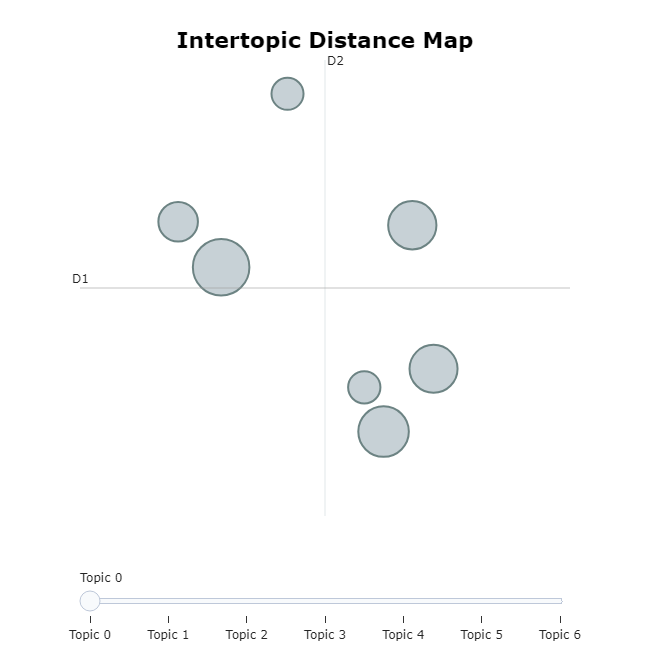

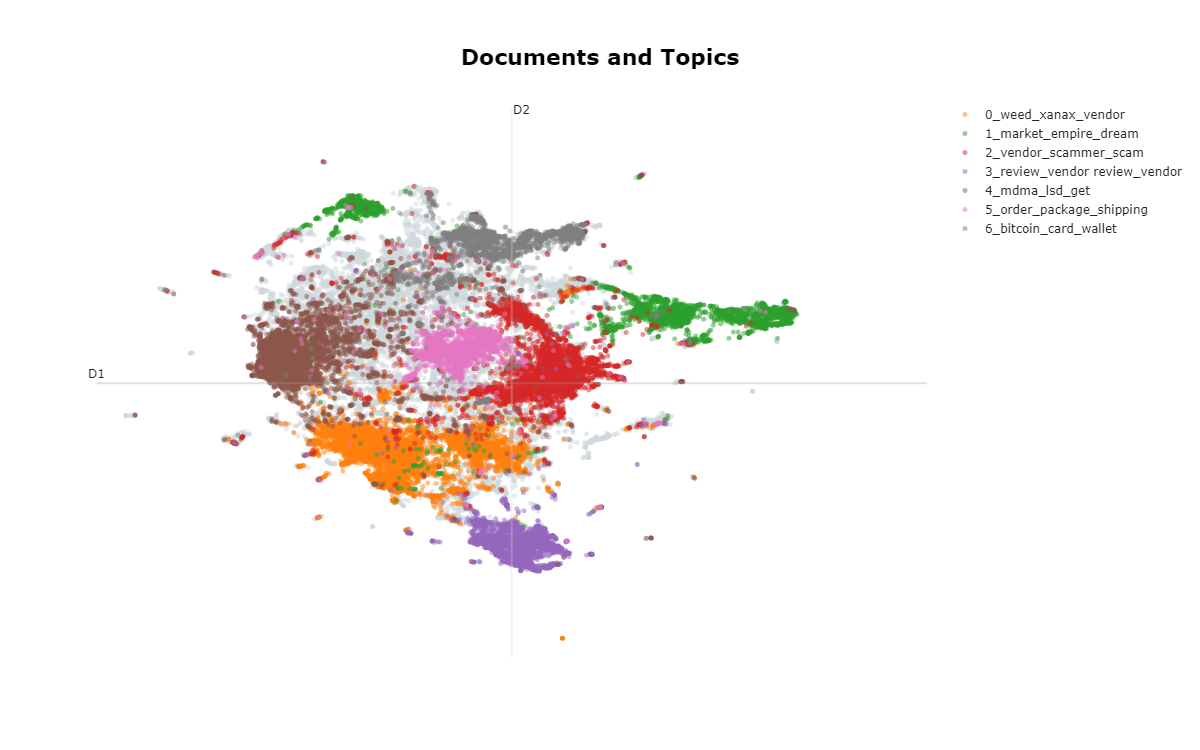

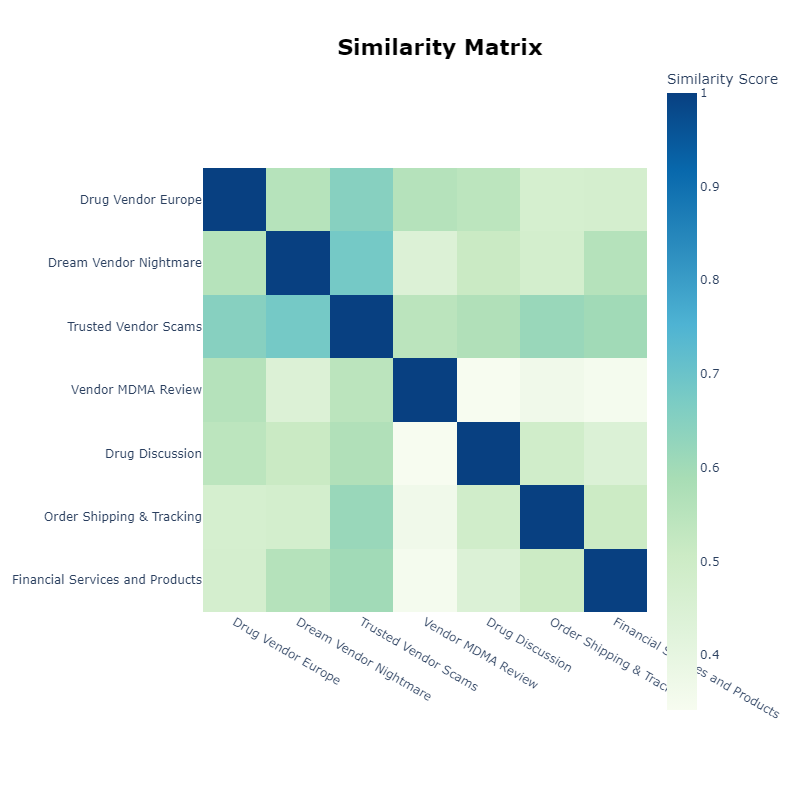
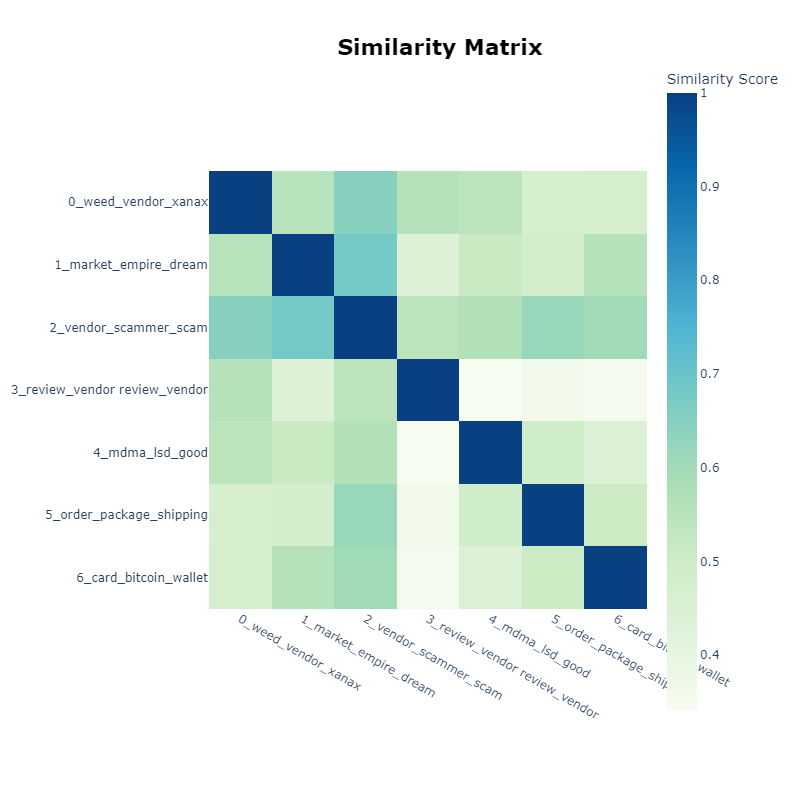

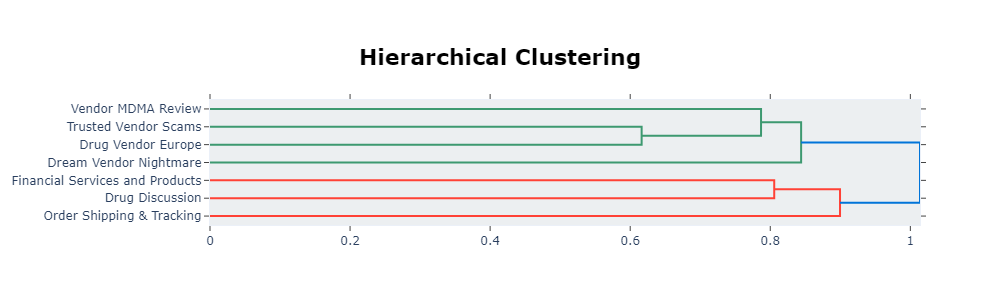

In [8]:
topic_model.visualize_barchart(top_n_topics=10, custom_labels=True, n_words=10, width=350, height=350)

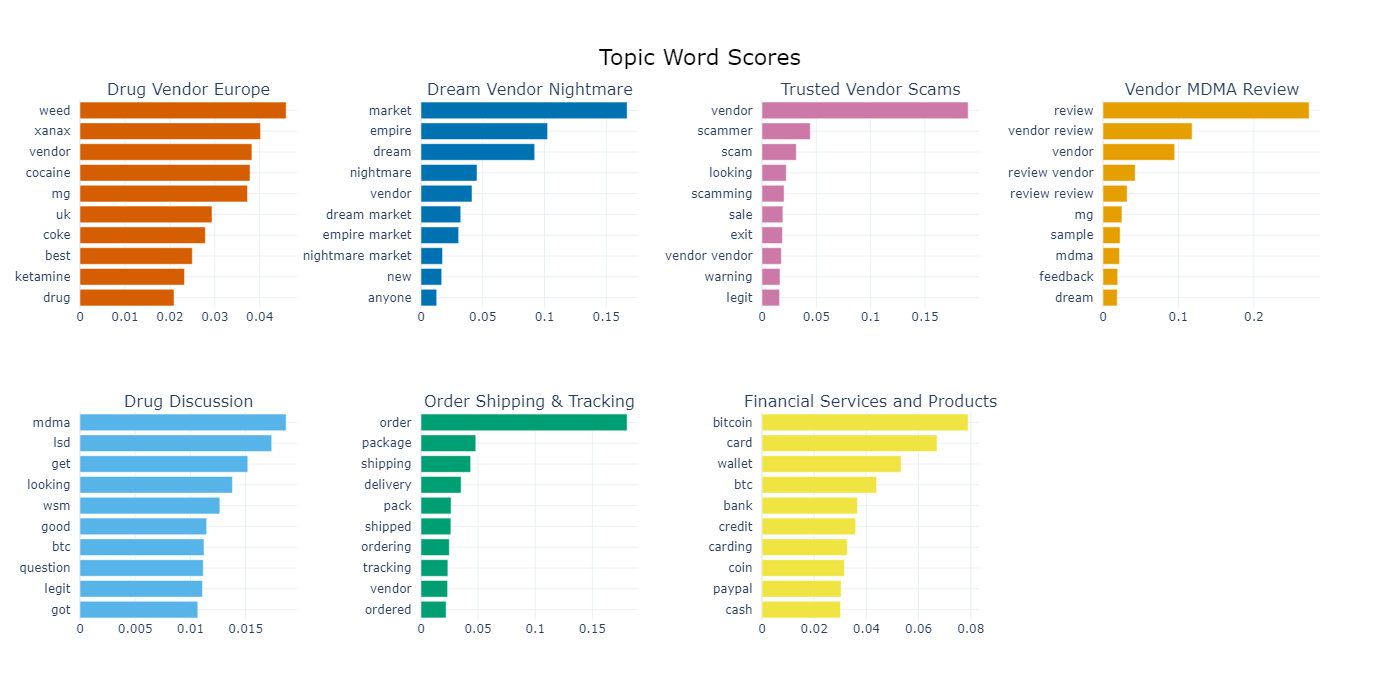

In [9]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10, width=1250, height=700, custom_labels=True)

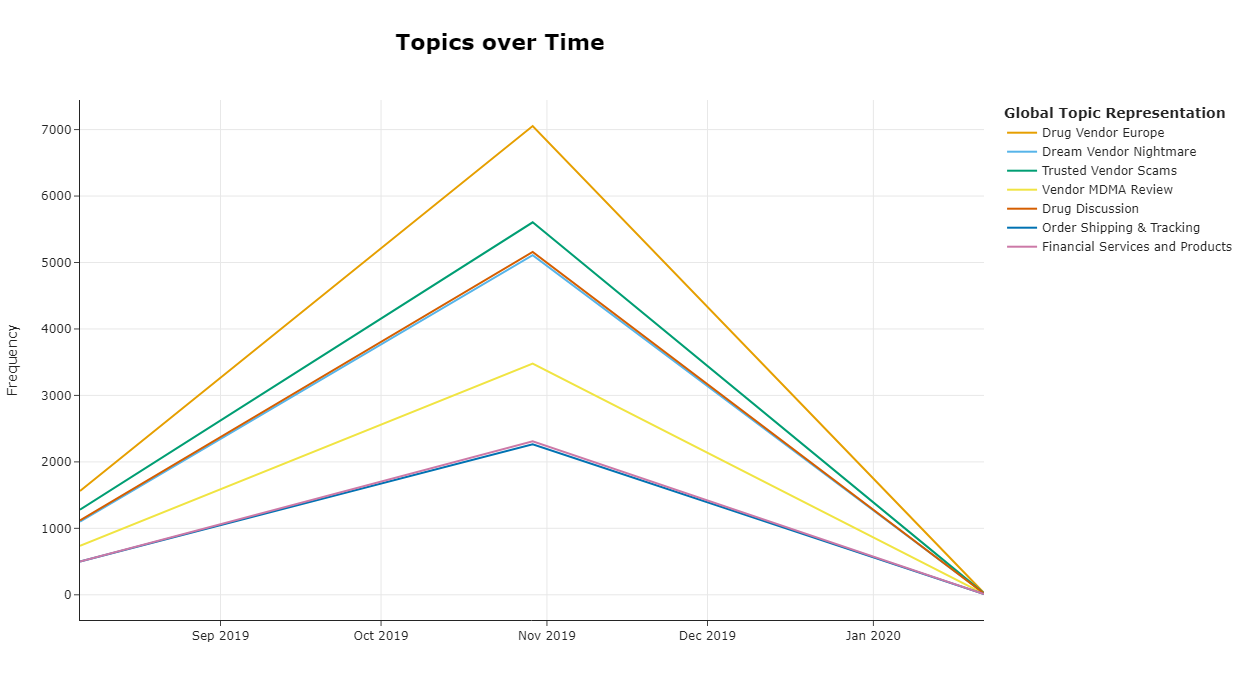

# Predict Models - Usage

In [12]:
topic_model = BERTopic.load("../../../Analyze_files/CombiningAnalysisCompleteDataset/ThreadAnalysis/Models/topic_model_0.64SilNew", embedding_model='distiluse-base-multilingual-cased-v1')

In [4]:
sentence = ['i want to by some xanax and guns and coke']
topic, _ = topic_model.transform(sentence)
topic_model.get_topic_info(topic[0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Topic  Count                         Name          CustomName  \
0      0   8645  0_weed_xanax_vendor_cocaine  Drug Vendor Europe   

                                      Representation  \
0  [weed, xanax, vendor, cocaine, mg, uk, coke, b...   

                                 Representative_Docs  
0  [high quality weed thc product europe, new xan...

In [5]:
sentence = ['really bad vendors he scammed me']
topic, _ = topic_model.transform(sentence)
topic_model.get_topic_info(topic[0])

Batches: 100%|██████████| 1/1 [00:00<00:00, 14.57it/s]


Topic  Count                           Name            CustomName  \
0      2   6907  2_vendor_scammer_scam_looking  Trusted Vendor Scams   

                                      Representation  \
0  [vendor, scammer, scam, looking, scamming, sal...   

                                 Representative_Docs  
0  [looking good reliable vendor sell ounce, vend...

In [6]:
sentence = ['xtc']
topic, _ = topic_model.transform(sentence)
topic_model.get_topic_info(topic[0])

Batches: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


Topic  Count                    Name       CustomName  \
0      4   6299  4_mdma_lsd_get_looking  Drug Discussion   

                                      Representation  \
0  [mdma, lsd, get, looking, wsm, good, btc, ques...   

                                 Representative_Docs  
0  [hey ro im gon na pull pk, life wonderful life...

In [7]:
sentence = ['closed market']
topic, _ = topic_model.transform(sentence)
topic_model.get_topic_info(topic[0])

Batches: 100%|██████████| 1/1 [00:00<00:00, 24.94it/s]


Topic  Count                             Name              CustomName  \
0      1   6236  1_market_empire_dream_nightmare  Dream Vendor Nightmare   

                                      Representation  \
0  [market, empire, dream, nightmare, vendor, dre...   

                                 Representative_Docs  
0  [next market, dream market vendor rstclass nig...

In [8]:
sentence = ['i want to buy coke cutted']
topic, _ = topic_model.transform(sentence)
topic_model.get_topic_info(topic[0])

Batches: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]


Topic  Count                         Name          CustomName  \
0      0   8645  0_weed_xanax_vendor_cocaine  Drug Vendor Europe   

                                      Representation  \
0  [weed, xanax, vendor, cocaine, mg, uk, coke, b...   

                                 Representative_Docs  
0  [high quality weed thc product europe, new xan...

# HuggingFace

In [ ]:
topic_model.push_to_hf_hub(
    repo_id="D0men1c0/ISSR_Dark_Web_7Topics",
    save_embedding_model='distiluse-base-multilingual-cased-v1',
    save_ctfidf=True
)

In [16]:
topic_model = BERTopic.load("D0men1c0/ISSR_Dark_Web_7Topics")

In [17]:
sentence = ['closed market']
topic, _ = topic_model.transform(sentence)
topic_model.get_topic_info(topic[0])

Batches: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
2024-07-31 13:17:35,319 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Topic  Count                             Name              CustomName  \
0      1   6236  1_market_empire_dream_nightmare  Dream Vendor Nightmare   

                                      Representation  Representative_Docs  
0  [market, empire, dream, nightmare, vendor, dre...                  NaN